In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
bucket_name = 'fake-news-data'

comments_df = pd.read_csv(f'gs://{bucket_name}/all_comments.tsv', sep='\t')
train_df = pd.read_csv(f'gs://{bucket_name}/multimodal_train_processed.csv')
validate_df = pd.read_csv(f'gs://{bucket_name}/multimodal_validate_processed.csv')
test_df = pd.read_csv(f'gs://{bucket_name}/multimodal_test_public_processed.csv')

## Basic understanding of the data

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396461 entries, 0 to 396460
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   author                        376185 non-null  object 
 1   clean_title                   396461 non-null  object 
 2   created_utc                   396461 non-null  float64
 3   domain                        278239 non-null  object 
 4   hasImage                      396461 non-null  bool   
 5   id                            396461 non-null  object 
 6   image_url                     395370 non-null  object 
 7   linked_submission_id          118222 non-null  object 
 8   num_comments                  278239 non-null  float64
 9   score                         396461 non-null  int64  
 10  subreddit                     396461 non-null  object 
 11  title                         396461 non-null  object 
 12  upvote_ratio                  278239 non-nul

In [4]:
train_df.describe()

,created_utc,num_comments,score,upvote_ratio,2_way_label,3_way_label,6_way_label,total_upvotes,avg_upvotes,upvotes_most_upvoted_comment
count,3.964610e+05,278239.000000,396461.000000,278239.000000,396461.000000,396461.000000,396461.000000,205006.000000,205006.000000,205006.000000
mean,1.478656e+09,20.372899,396.097243,0.855380,0.393456,1.188425,1.885933,503.184268,4.957638,97.265817
std,6.976002e+07,141.397193,3053.114162,0.110169,0.488517,0.969451,1.782927,4234.224290,15.612458,698.278027
min,1.212297e+09,0.000000,-236.000000,0.500000,0.000000,0.000000,0.000000,-960.000000,-16.000000,-16.000000
25%,1.417976e+09,1.000000,5.000000,0.780000,0.000000,0.000000,0.000000,3.000000,1.052632,2.000000
50%,1.488929e+09,2.000000,14.000000,0.880000,0.000000,2.000000,2.000000,8.000000,2.000000,3.000000
75%,1.550480e+09,7.000000,46.000000,0.940000,1.000000,2.000000,4.000000,29.000000,3.768784,10.000000
max,1.571839e+09,9383.000000,137179.000000,1.000000,1.000000,2.000000,5.000000,414104.000000,1435.628571,42573.000000


## Check for missing values

In [5]:
# Check for missing data
train_df.isnull().sum()

author                           20276
clean_title                          0
created_utc                          0
domain                          118222
hasImage                             0
id                                   0
image_url                         1091
linked_submission_id            278239
num_comments                    118222
score                                0
subreddit                            0
title                                0
upvote_ratio                    118222
2_way_label                          0
3_way_label                          0
6_way_label                          0
total_upvotes                   191455
avg_upvotes                     191455
submission_id                   191455
most_upvoted_comment            191462
upvotes_most_upvoted_comment    191455
dtype: int64

## Basic visualization of data

In [6]:
def visualize_numerical_data(df, col):    
    df[col].hist(bins=50)
    plt.xlabel(col)
    plt.title('Distribution of {}'.format(col))
    plt.show()

In [7]:
def visualize_categorical_data(df, col):
    df[col].value_counts().plot(kind='bar')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title('Distribution of {}'.format(col))
    plt.show()

In [8]:
def visualize_bar_plot(df, col):
    df[col].value_counts().nlargest(30).plot(kind='bar', figsize=(10,5))
    plt.title("Number of entries in each {}".format(col))
    plt.ylabel("Number of entries")
    plt.xlabel(col)
    plt.show()

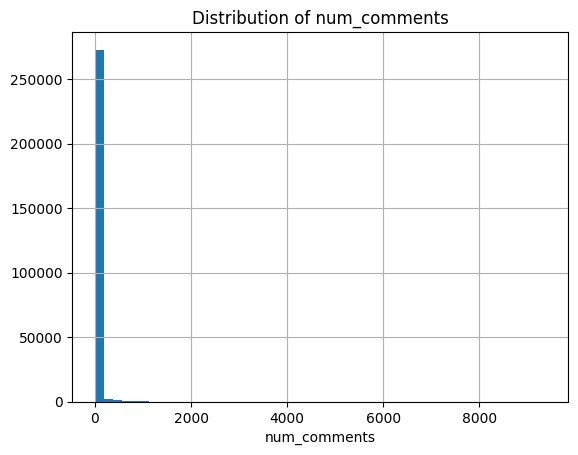

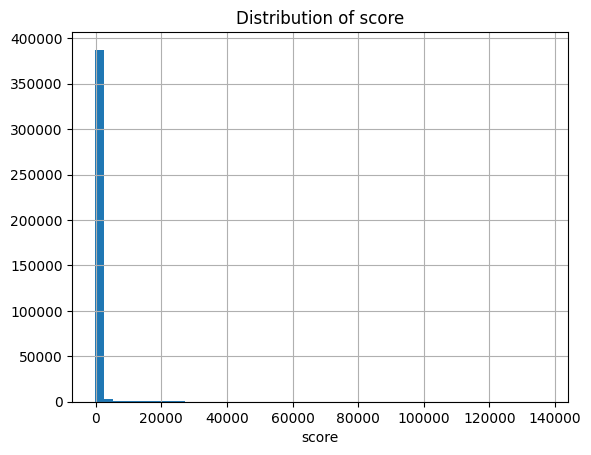

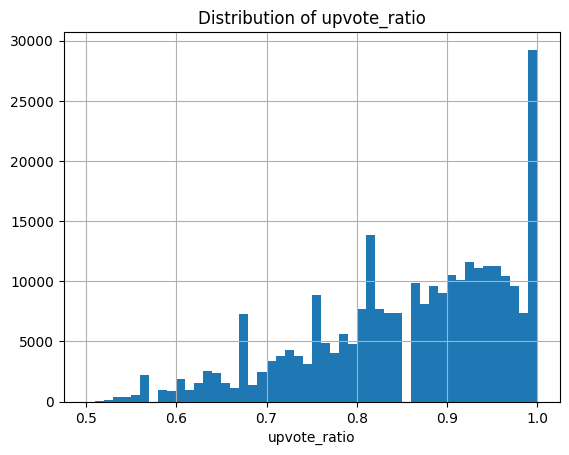

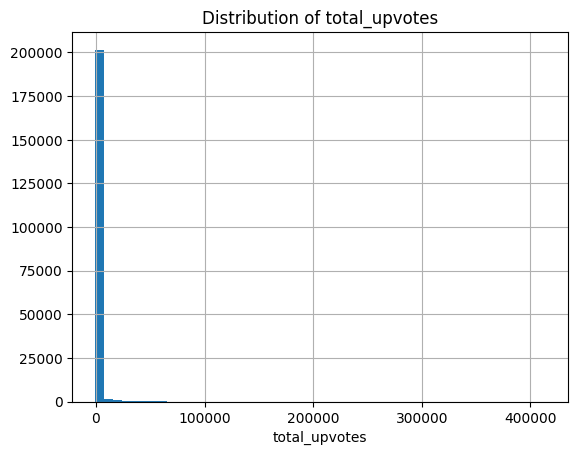

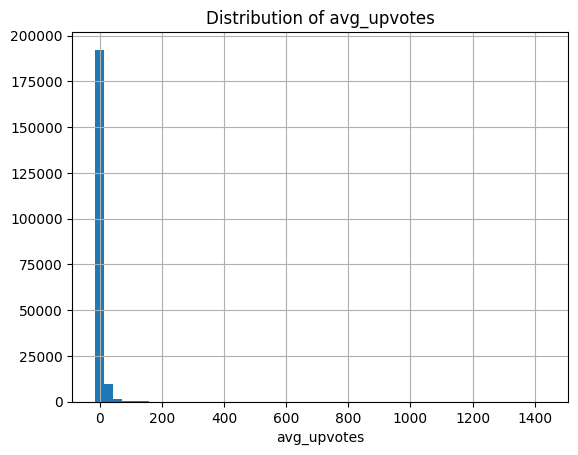

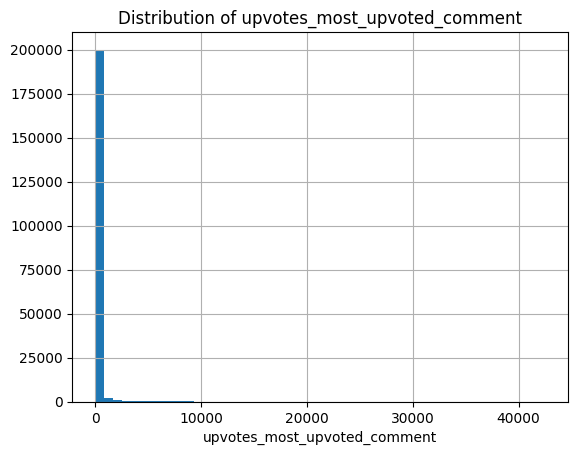

In [9]:
# Numerical columns
numerical_columns = ['num_comments', 'score', 'upvote_ratio', 'total_upvotes', 'avg_upvotes', 'upvotes_most_upvoted_comment']

for col in numerical_columns:
    visualize_numerical_data(train_df, col)

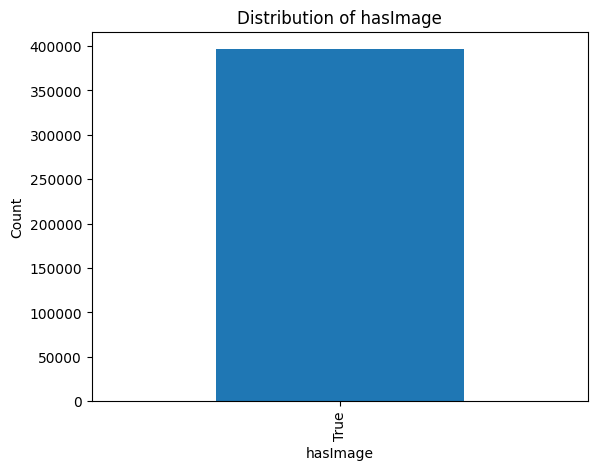

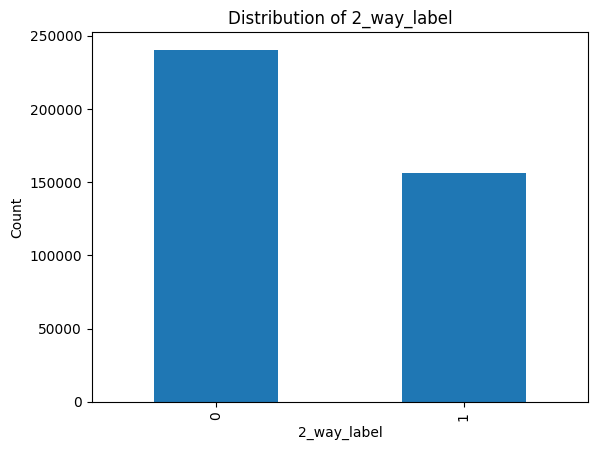

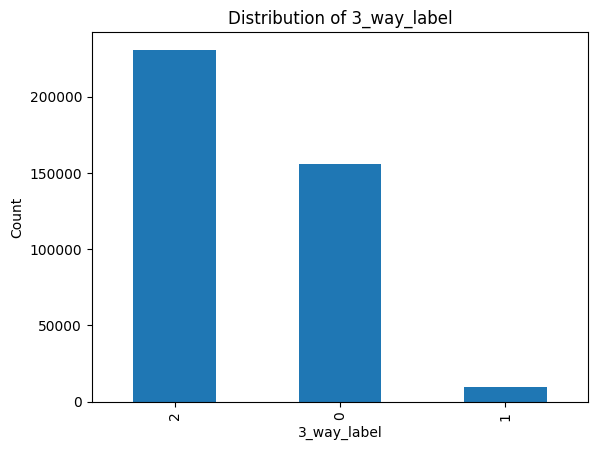

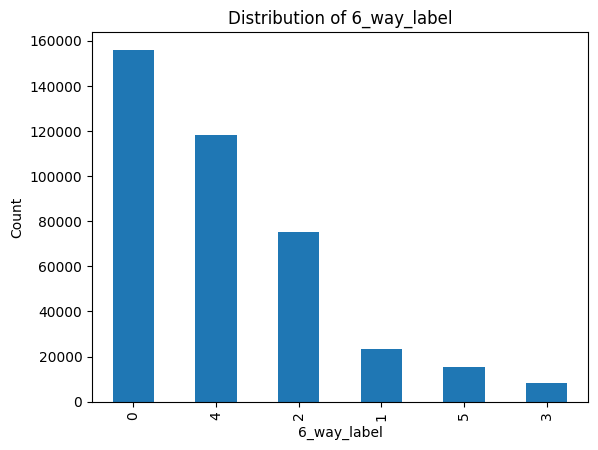

In [10]:
# Categorical columns
categorical_columns = ['hasImage', '2_way_label', '3_way_label', '6_way_label']

for col in categorical_columns:
    visualize_categorical_data(train_df, col)

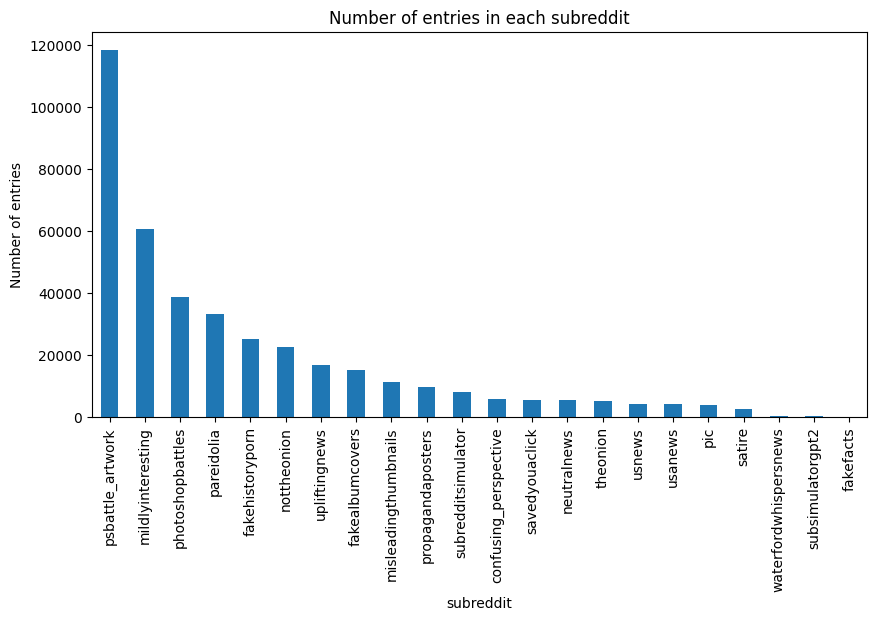

In [11]:
# Columns suitable for bar plot
bar_plot_columns = ['subreddit']  

for col in bar_plot_columns:
    visualize_bar_plot(train_df, col)

## Understanding the target variable

<AxesSubplot:>

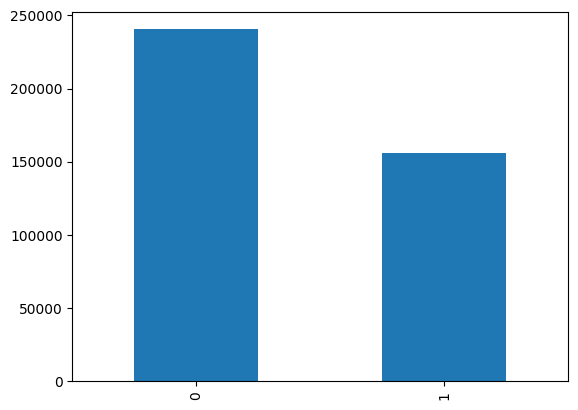

In [12]:
train_df['2_way_label'].value_counts().plot(kind='bar')

<AxesSubplot:>

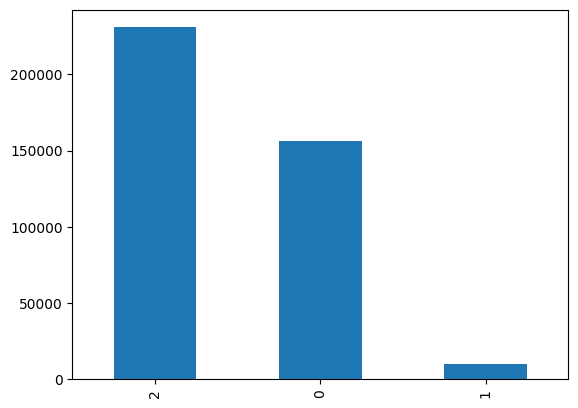

In [13]:
train_df['3_way_label'].value_counts().plot(kind='bar')

<AxesSubplot:>

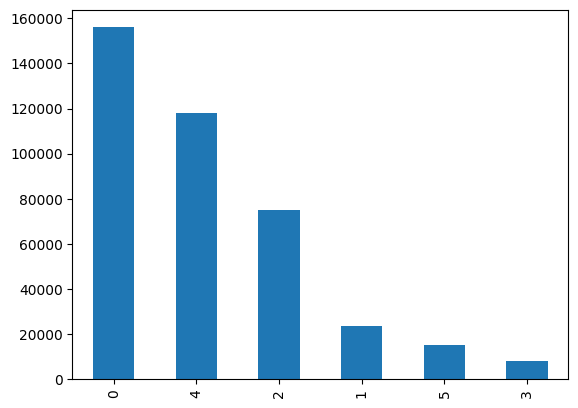

In [14]:
train_df['6_way_label'].value_counts().plot(kind='bar')

## Visualize textual data using LDA

In [15]:
import gensim
from gensim import corpora
from gensim.models import LdaMulticore
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.gensim_models
import nltk
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def process_text(text):
    if type(text) == float:
        return ''
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return filtered_tokens

def visualize_text(df, col):
    df[col] = df[col].apply(lambda x: ' '.join(process_text(x)))
    # Tokenize the text
    tokens = df[col].apply(word_tokenize)

    # Create a Gensim dictionary from the tokens
    dictionary = corpora.Dictionary(tokens)

    # Convert tokens to vectors
    corpus = [dictionary.doc2bow(token) for token in tokens]

    # Train the LDA model
    lda_model = LdaMulticore(corpus, num_topics=10, id2word=dictionary, passes=15, workers=6)

    # Visualize the topics
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
    return vis


[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Topic Modelling on textual data

In [16]:
visualize_text(train_df, 'clean_title')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.139044 -0.134151       1        1  13.535630
5     -0.199274 -0.108140       2        1  12.935231
0      0.030938 -0.250360       3        1  12.523717
3      0.187661  0.143585       4        1  10.595023
6      0.156869  0.171080       5        1  10.238120
4      0.050490 -0.101172       6        1   8.975314
9      0.150098  0.026248       7        1   8.781422
1     -0.198615 -0.027834       8        1   8.449326
7     -0.109032  0.051964       9        1   7.227289
8     -0.208181  0.228780      10        1   6.738929, topic_info=             Term          Freq         Total Category  logprob  loglift
164          like  11562.000000  11562.000000  Default  30.0000  30.0000
324           dog   6748.000000   6748.000000  Default  29.0000  29.0000
77            cat   6345.000000   6345.000000  Default  28.0000  28.0000
197   discussions   5850.000000   5850.000000  Default  27.0000  27.0000
165         looks   7266.000000   7266.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
342         weird    475.754213    706.826094  Topic10  -5.6101   2.3014
75           seen    572.839812   1488.785018  Topic10  -5.4244   1.7422
222           new    925.755882   8085.412940  Topic10  -4.9444   0.5301
1807         half    456.655361    981.334803  Topic10  -5.6511   1.9323
10           tiny    469.131114   1316.861488  Topic10  -5.6241   1.6651

[468 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
37        7  0.999600     ad
223       1  0.998604    ago
853       1  0.000707    air
853       2  0.182289    air
853       4  0.520017    air
...     ...       ...    ...
651       4  0.011097  young
651       5  0.227116  young
651       6  0.528211  young
651       8  0.002219  young
1931      3  0.998733  youre

[632 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 1, 4, 7, 5, 10, 2, 8, 9])

In [17]:
visualize_text(train_df, 'most_upvoted_comment')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.215468 -0.046642       1        1  22.303607
2      0.219907 -0.133941       2        1  11.805755
6      0.119339  0.150335       3        1  10.615392
8     -0.306622 -0.199974       4        1  10.370076
1     -0.314593 -0.046640       5        1   9.937659
3      0.187045 -0.044265       6        1   9.363457
7      0.157106 -0.150712       7        1   8.783833
9     -0.060253  0.246194       8        1   6.997984
0     -0.196748  0.016892       9        1   5.244123
4     -0.020650  0.208751      10        1   4.578114, topic_info=           Term          Freq         Total Category  logprob  loglift
135       https  39821.000000  39821.000000  Default  30.0000  30.0000
8          http  42663.000000  42663.000000  Default  29.0000  29.0000
16         like  20976.000000  20976.000000  Default  28.0000  28.0000
150     deleted   9771.000000   9771.000000  Default  27.0000  27.0000
167      please  17833.000000  17833.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
3552       blue    287.978808    502.580450  Topic10  -5.7602   2.5270
5415  thumbnail    271.207784    442.871420  Topic10  -5.8202   2.5935
370        hair    253.430947    399.282329  Topic10  -5.8880   2.6293
15         kind    272.201338   1747.572309  Topic10  -5.8165   1.2244
4425      giant    250.302520    463.306331  Topic10  -5.9004   2.4682

[628 rows x 6 columns], token_table=       Topic      Freq Term
term                       
2149       8  0.999005  039
1089       8  0.845013    1
1089       9  0.154480    1
821        1  0.889319   10
821        8  0.108842   10
...      ...       ...  ...
1293       3  0.067590  yes
1293       7  0.161919  yes
343        7  0.996355   yo
8710       9  0.993666  yup
10304      4  0.993674   är

[1086 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 7, 9, 2, 4, 8, 10, 1, 5])

## Sentiment Analysis on Title and Comment

In [18]:
from textblob import TextBlob

# Function to calculate sentiment
def calculate_sentiment(text: str) -> float:
    return TextBlob(text).sentiment.polarity

# Apply function to your text data
train_df['title_sentiment'] = train_df['clean_title'].apply(calculate_sentiment)
train_df['comment_sentiment'] = train_df['most_upvoted_comment'].apply(calculate_sentiment)


Text(0.5, 0, 'Title Sentiment Score')

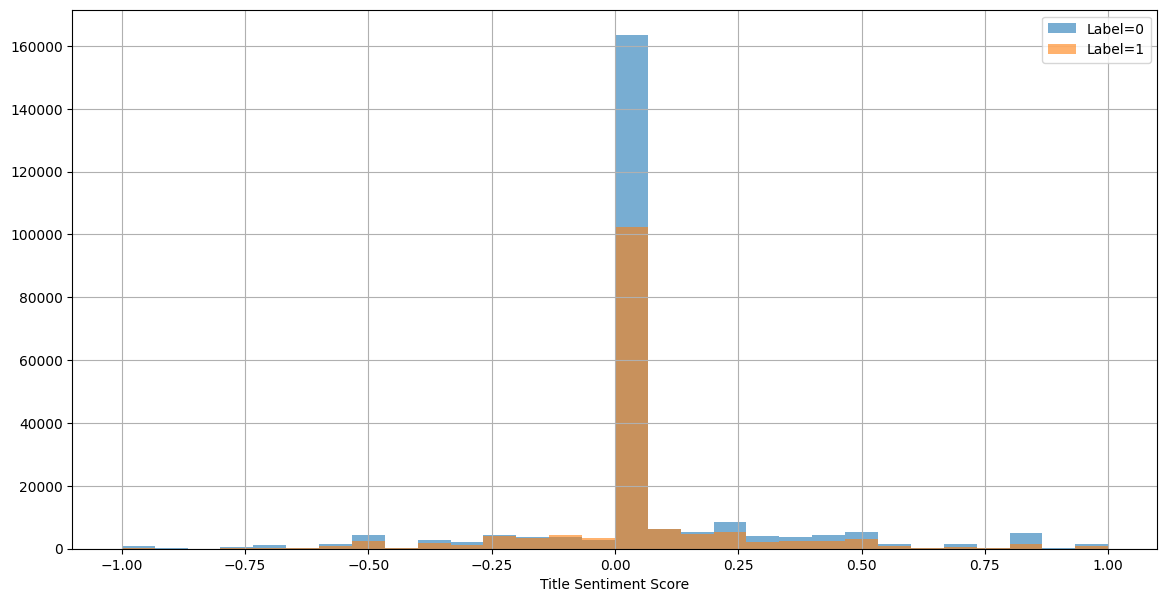

In [19]:
# Plotting sentiment distribution for each label
plt.figure(figsize=(14,7))
train_df[train_df['2_way_label'] == 0]['title_sentiment'].hist(alpha = 0.6, bins=30, label='Label=0')
train_df[train_df['2_way_label'] == 1]['title_sentiment'].hist(alpha = 0.6, bins=30, label='Label=1')
plt.legend()
plt.xlabel('Title Sentiment Score')

In [20]:
"""# Plotting sentiment distribution for each label
plt.figure(figsize=(14,7))
train_df[train_df['2_way_label'] == 0]['most_upvoted_comment'].hist(alpha = 0.6, bins=30, label='Label=0')
train_df[train_df['2_way_label'] == 1]['most_upvoted_comment'].hist(alpha = 0.6, bins=30, label='Label=1')
plt.legend()
plt.xlabel('Comment Sentiment Score')"""

"# Plotting sentiment distribution for each label\nplt.figure(figsize=(14,7))\ntrain_df[train_df['2_way_label'] == 0]['most_upvoted_comment'].hist(alpha = 0.6, bins=30, label='Label=0')\ntrain_df[train_df['2_way_label'] == 1]['most_upvoted_comment'].hist(alpha = 0.6, bins=30, label='Label=1')\nplt.legend()\nplt.xlabel('Comment Sentiment Score')"

## Visualize Unigrams and Bigrams

In [21]:
from collections import Counter
from nltk.util import ngrams

def get_ngrams(text, n):
    tokens = process_text(text)
    return list(ngrams(tokens, n))

def count_ngrams(df, column, n, label_col, label):
    ngrams_list = df[df[label_col]==label][column].apply(lambda x: get_ngrams(x, n))
    ngrams_counter = Counter()
    
    for ngram in ngrams_list:
        ngrams_counter.update(ngram)
    
    return ngrams_counter

def plot_ngrams(counter, n, num_most_common):
    most_common_ngrams = counter.most_common(num_most_common)
    ngram_names = [' '.join(ngram) for ngram, count in most_common_ngrams]
    ngram_counts = [count for ngram, count in most_common_ngrams]

    plt.figure(figsize=(15,5))
    plt.bar(ngram_names, ngram_counts)
    plt.title(f'Top {num_most_common} most common {n}-grams')
    plt.xticks(rotation=45)
    plt.show()

### Visualize for 2_way_label

Label: 1


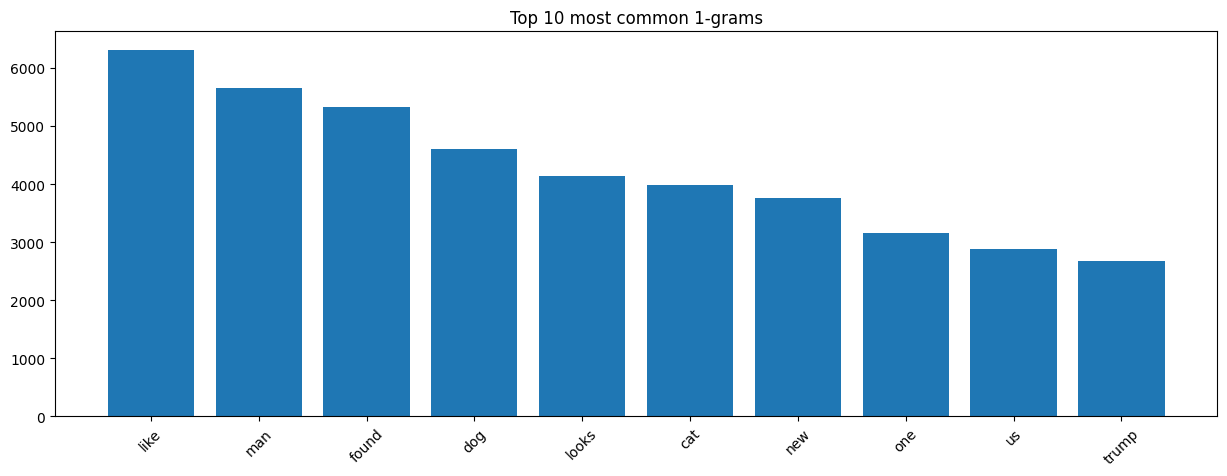

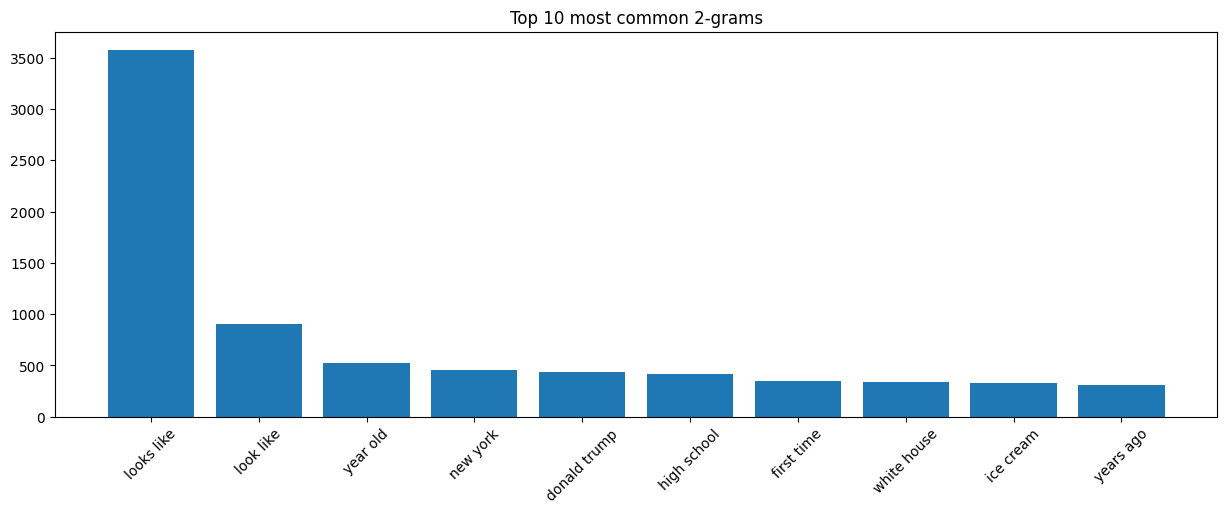

Label: 0


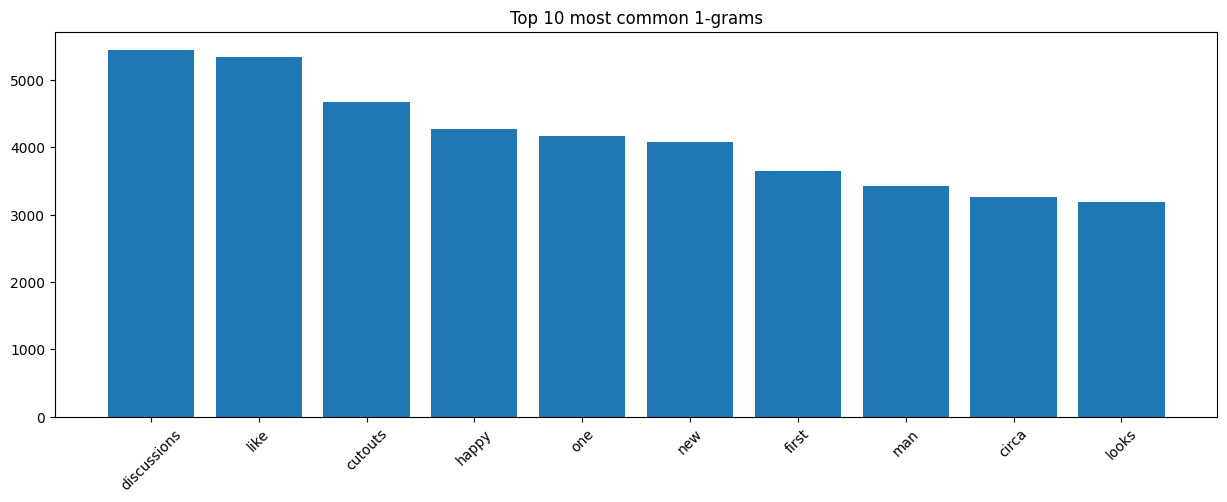

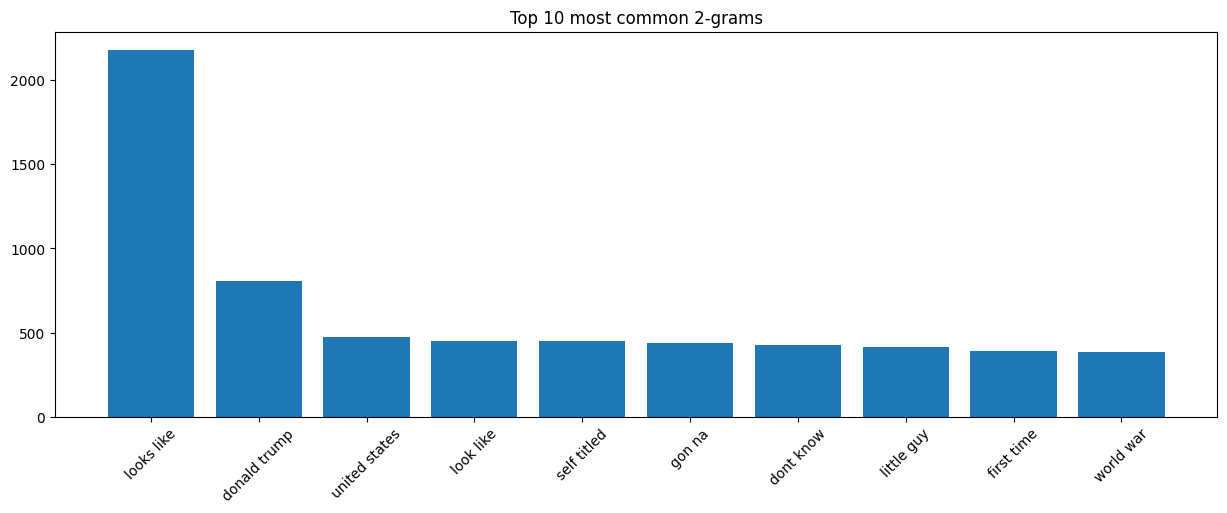

In [22]:
for label in train_df['2_way_label'].unique():
    unigram_counter = count_ngrams(train_df, 'clean_title', 1, '2_way_label', label)
    bigram_counter = count_ngrams(train_df, 'clean_title', 2, '2_way_label', label)

    print(f'Label: {label}')
    plot_ngrams(unigram_counter, 1, 10)
    plot_ngrams(bigram_counter, 2, 10)

### Visualize for 3_way_label 

Label: 0


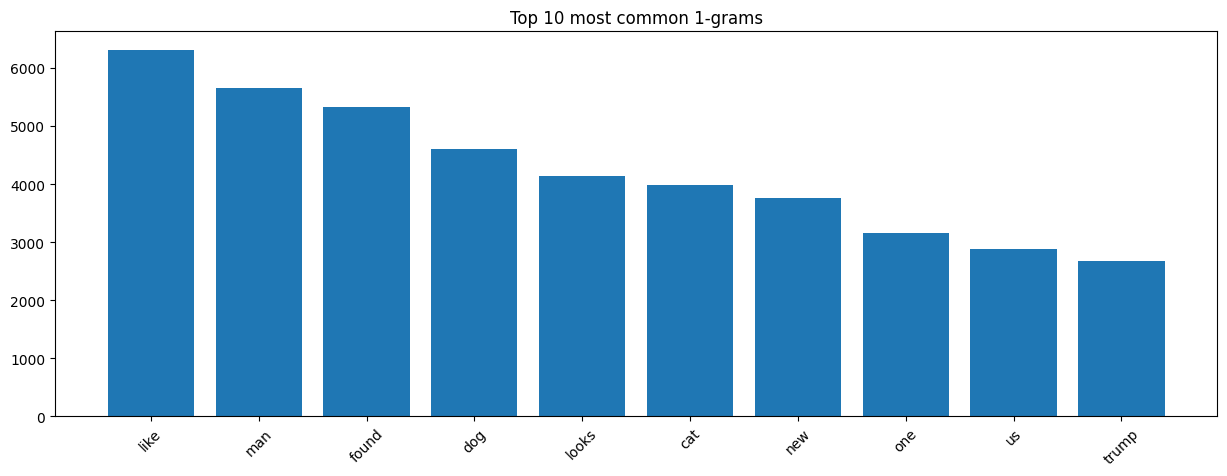

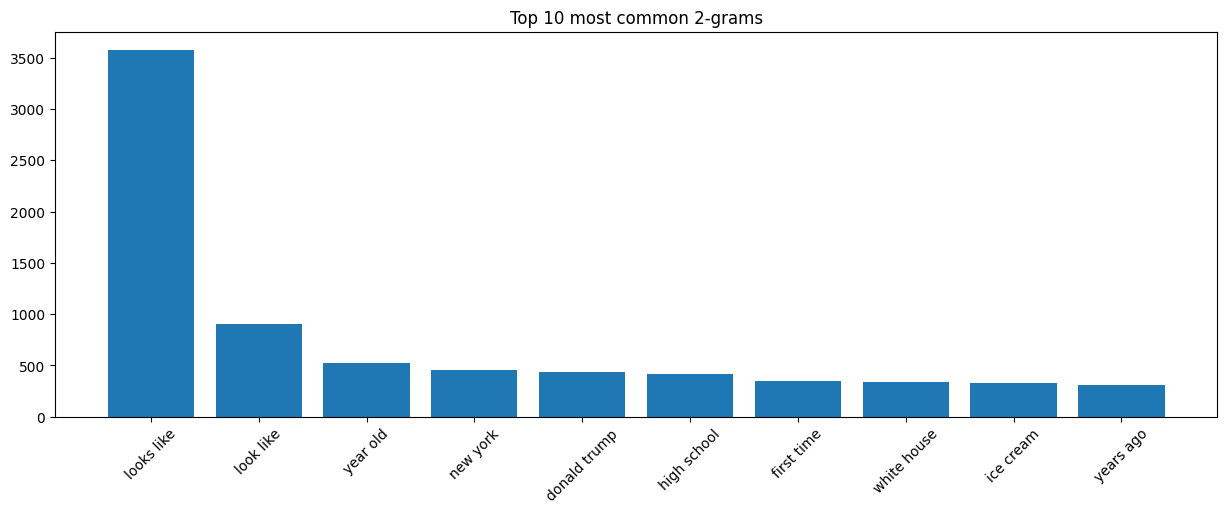

Label: 2


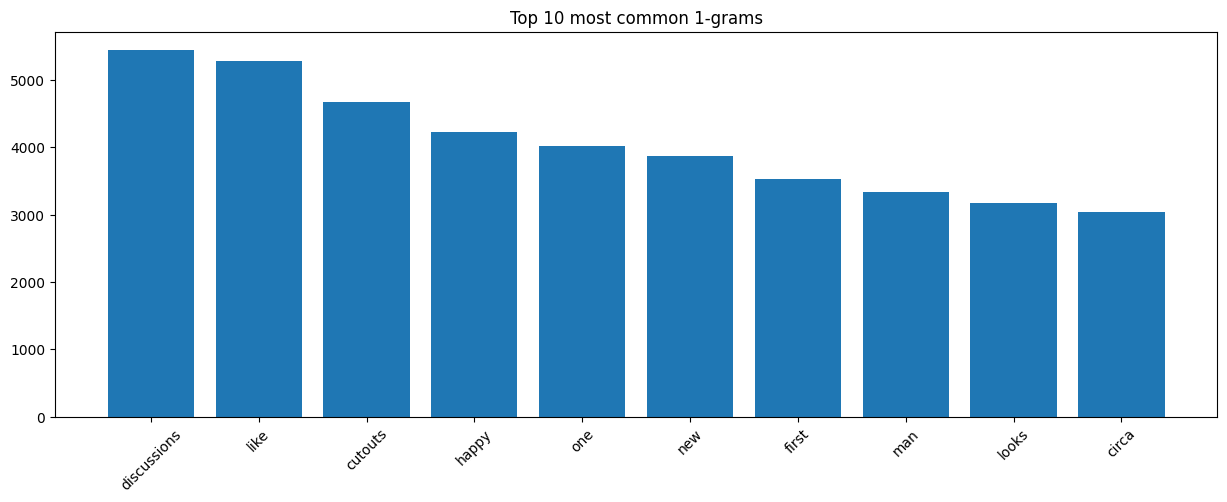

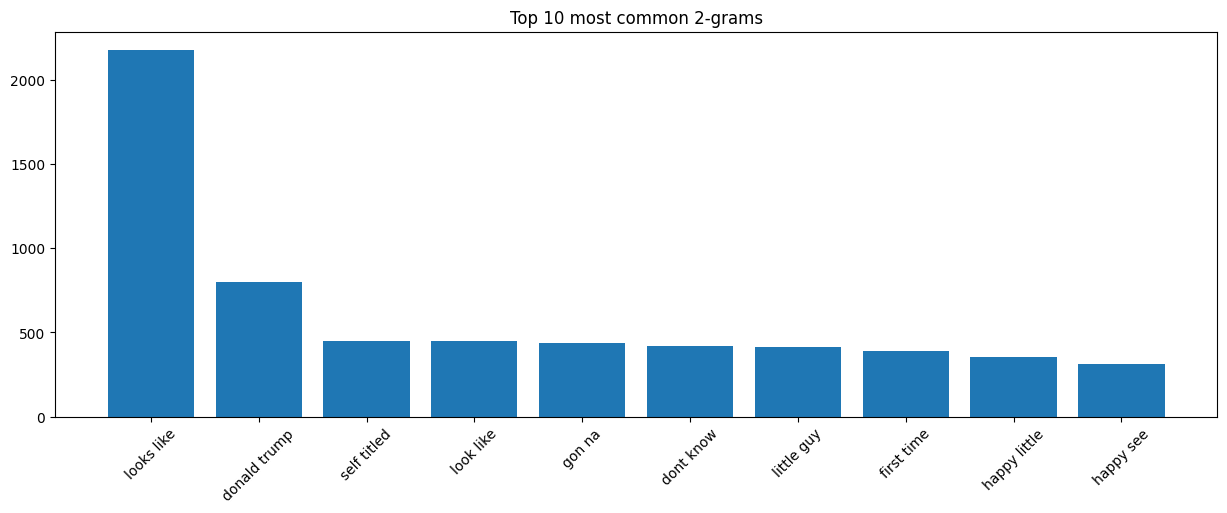

Label: 1


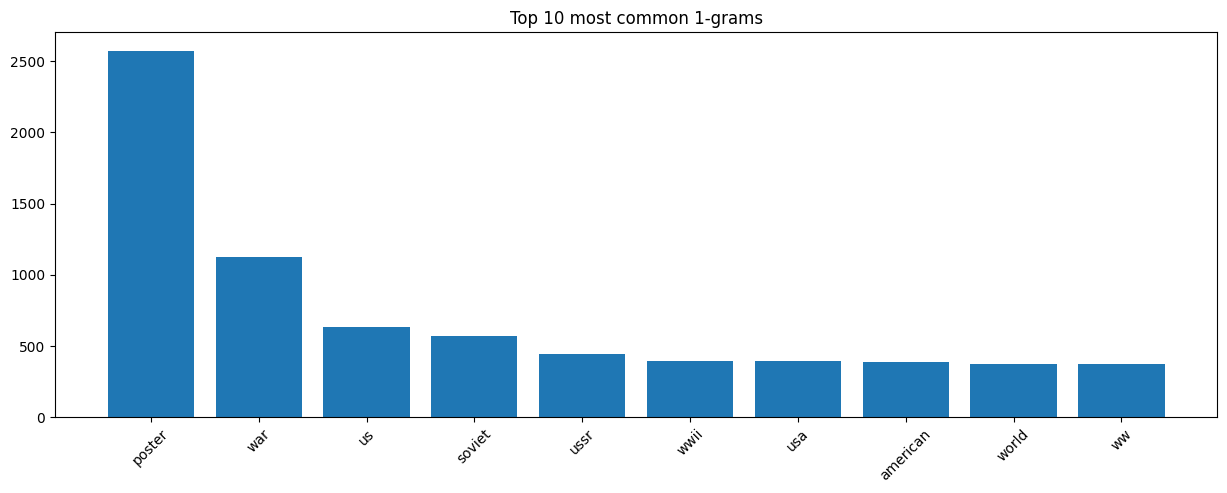

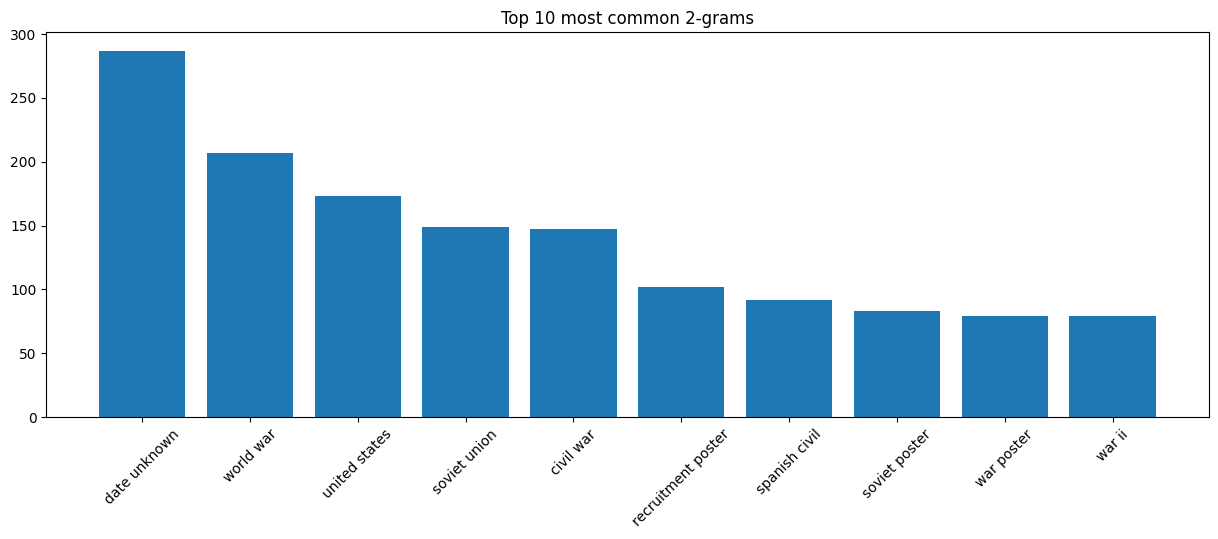

In [23]:
for label in train_df['3_way_label'].unique():
    unigram_counter = count_ngrams(train_df, 'clean_title', 1, '3_way_label', label)
    bigram_counter = count_ngrams(train_df, 'clean_title', 2, '3_way_label', label)

    print(f'Label: {label}')
    plot_ngrams(unigram_counter, 1, 10)
    plot_ngrams(bigram_counter, 2, 10)

### Visualize for 6_way_label

Label: 0


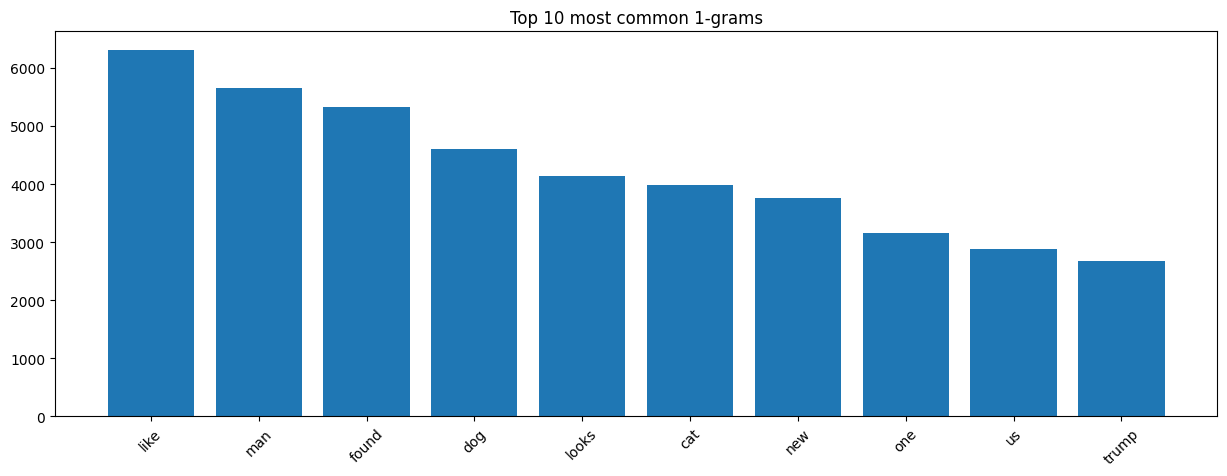

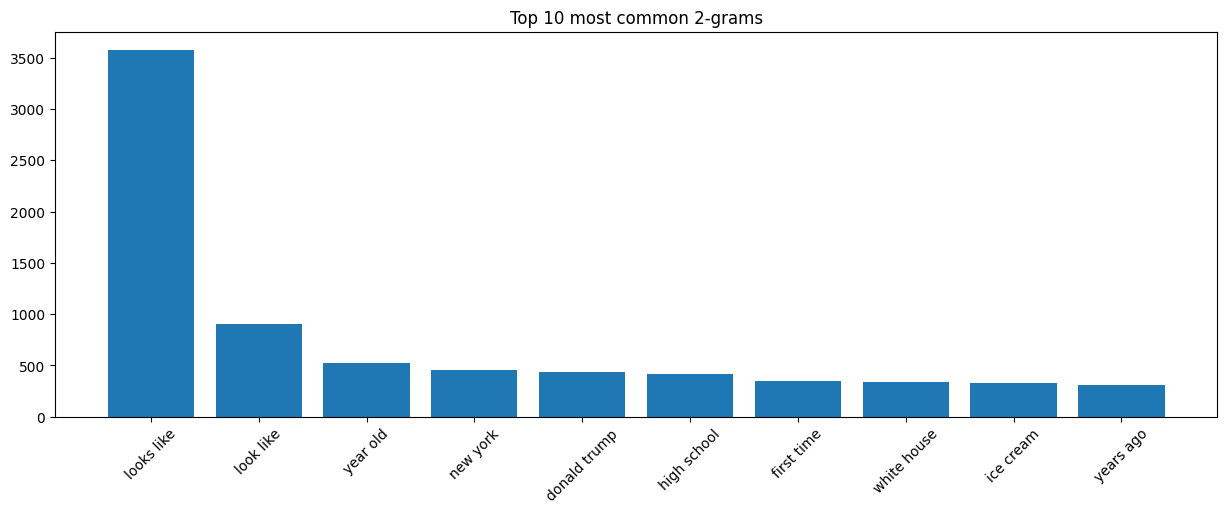

Label: 2


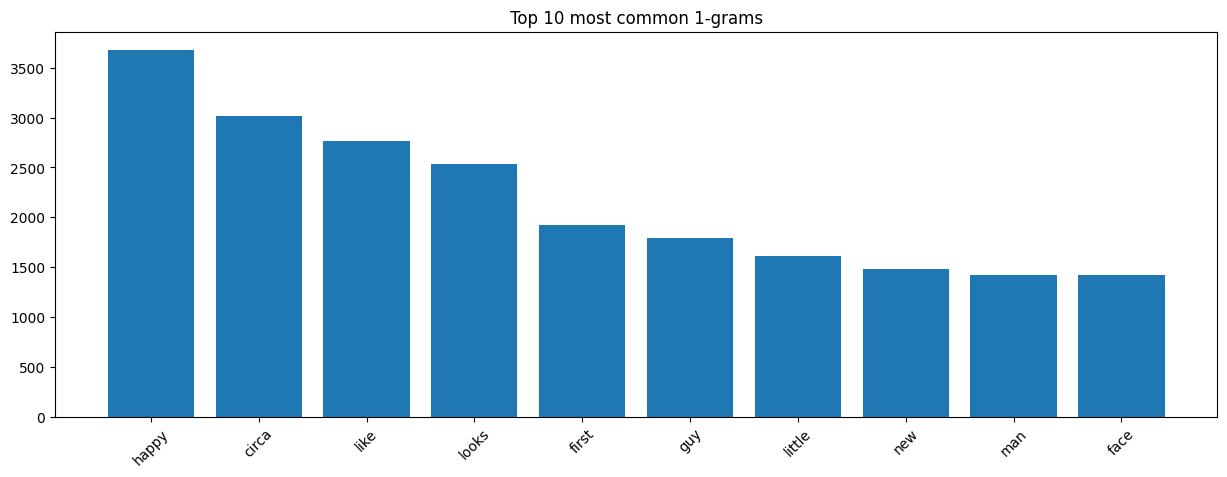

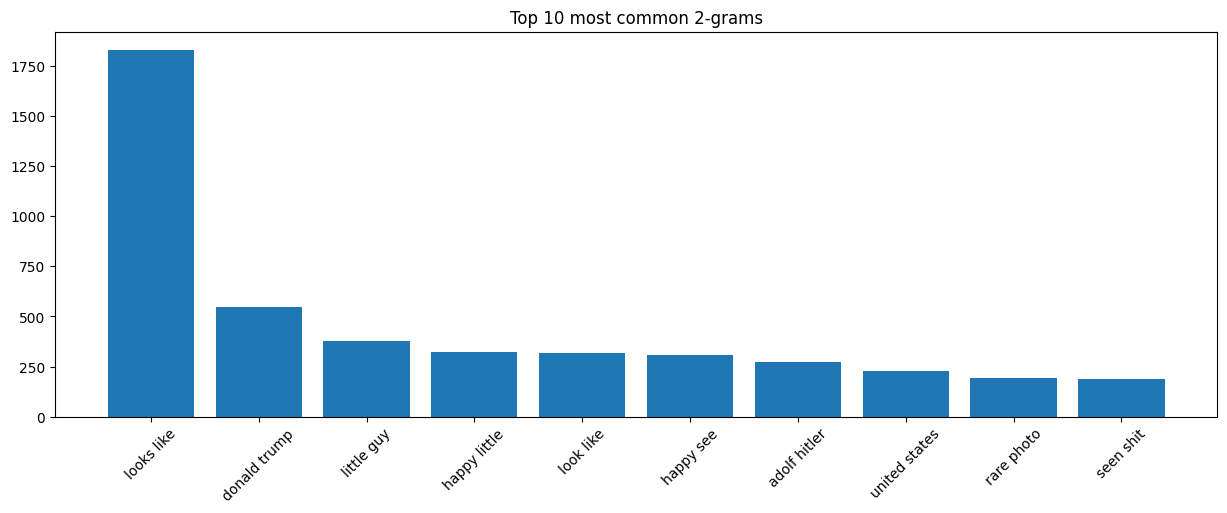

Label: 4


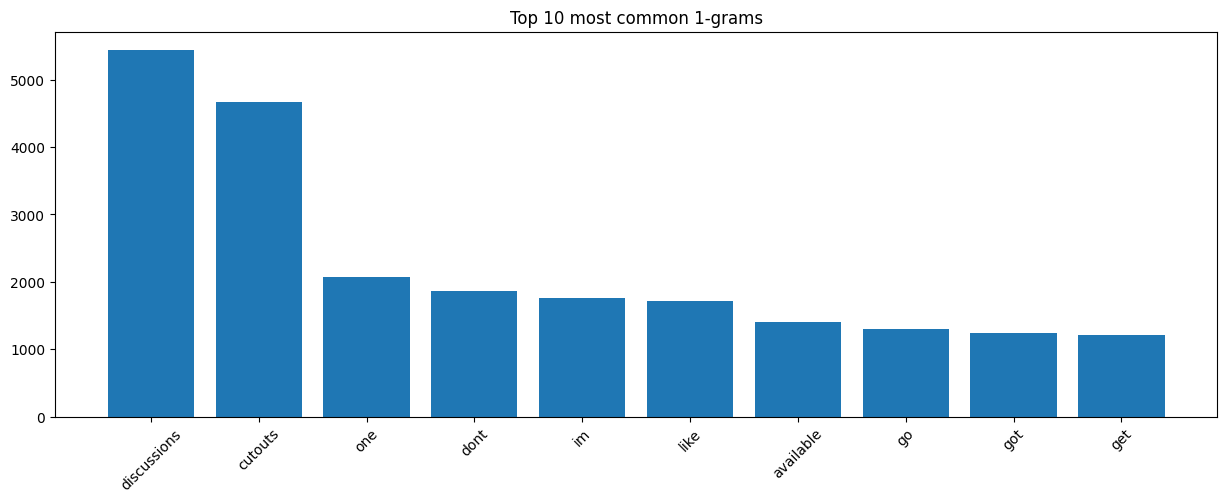

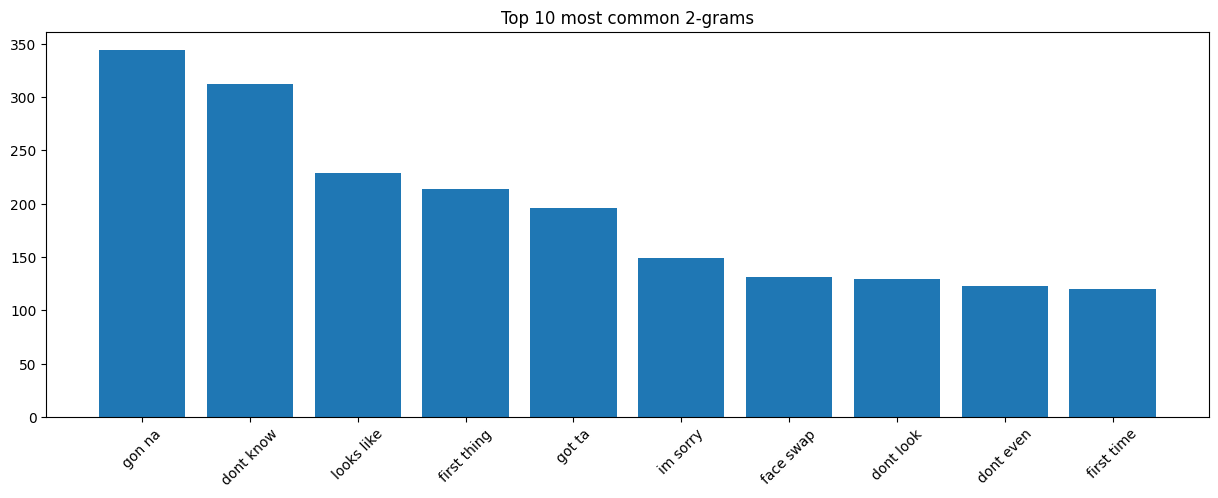

Label: 5


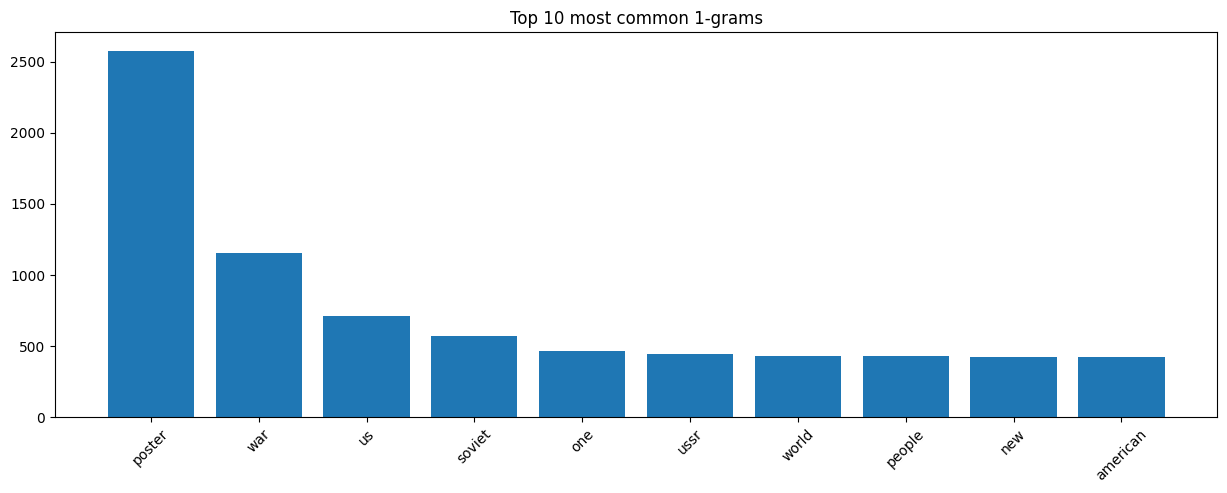

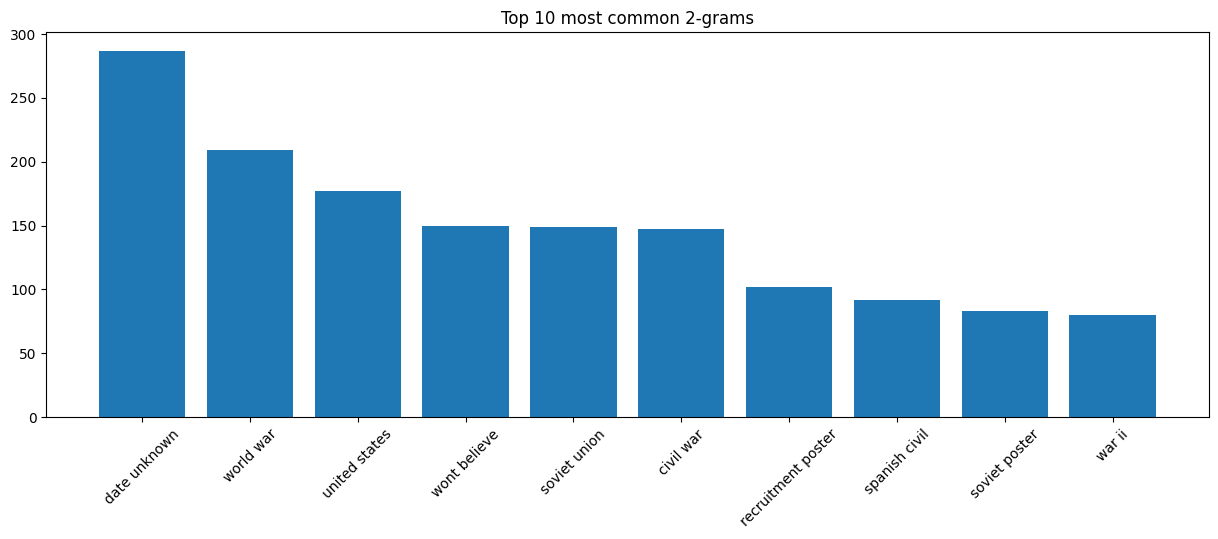

Label: 1


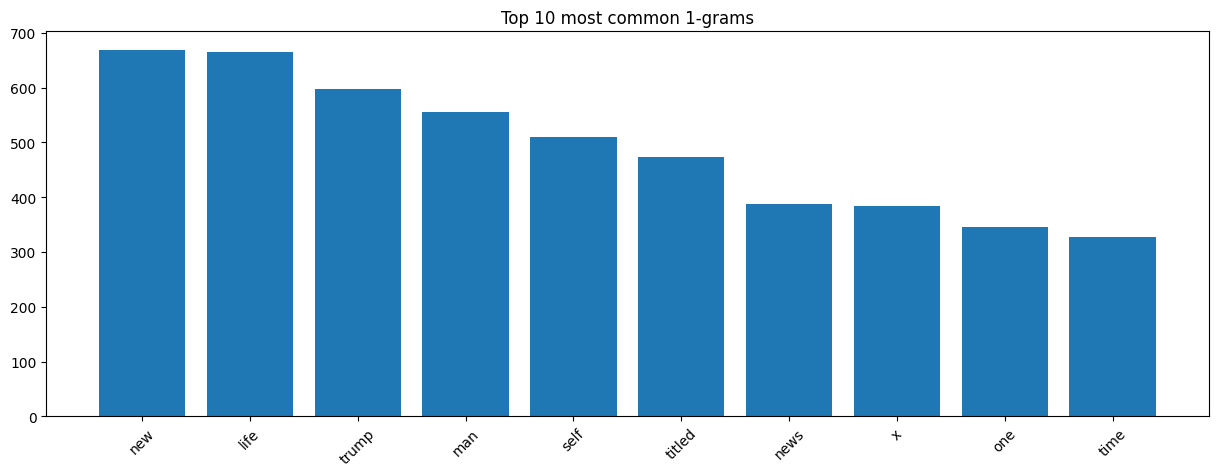

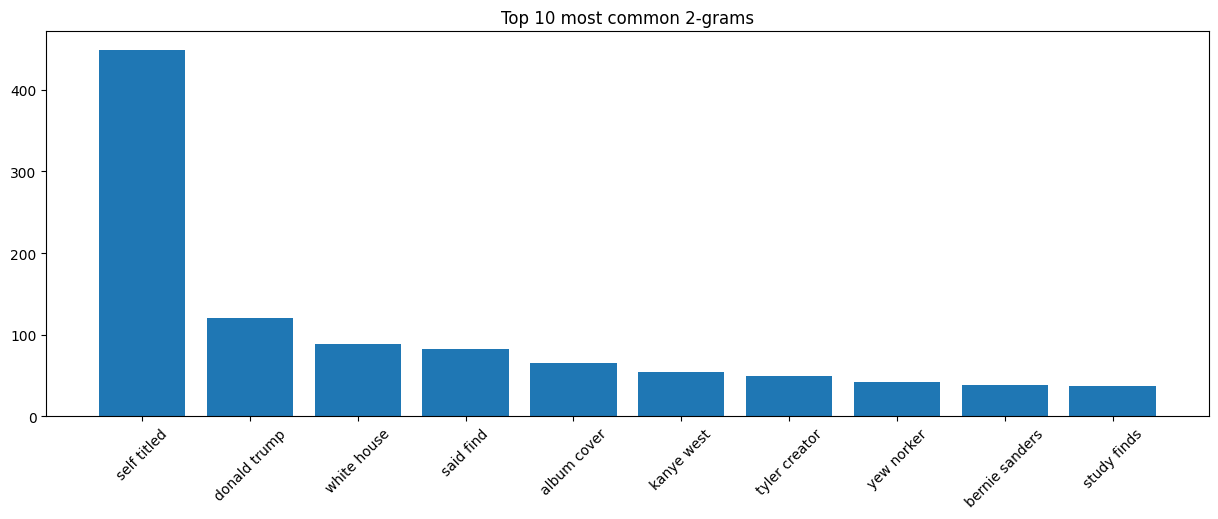

Label: 3


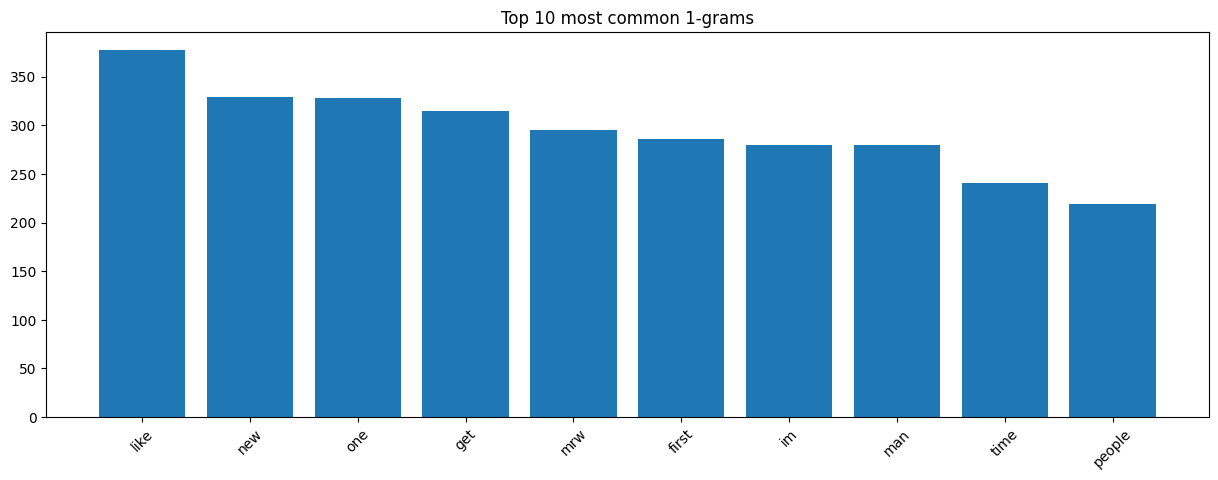

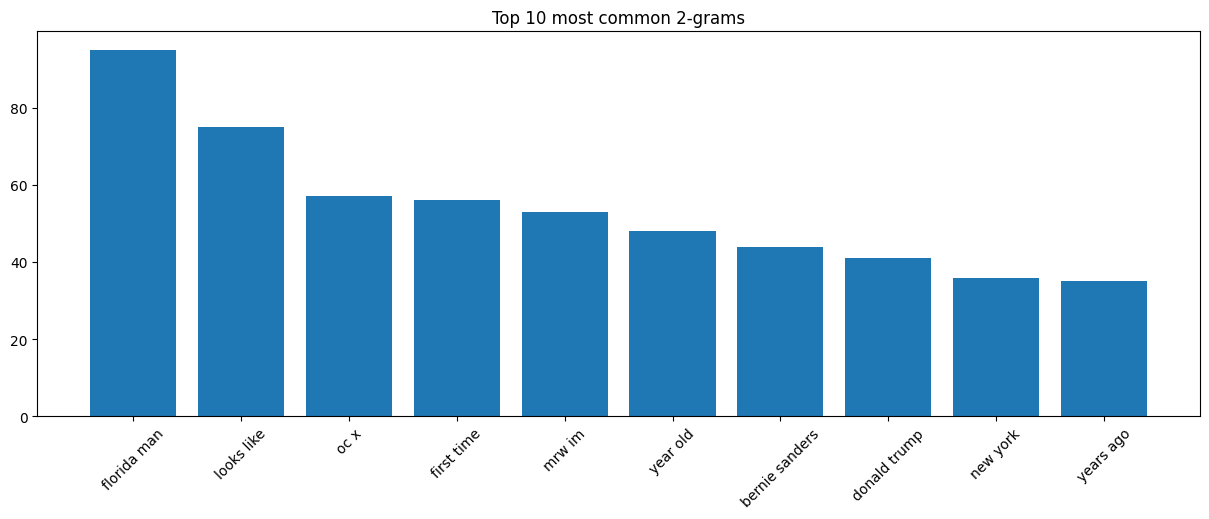

In [24]:
for label in train_df['6_way_label'].unique():
    unigram_counter = count_ngrams(train_df, 'clean_title', 1, '6_way_label', label)
    bigram_counter = count_ngrams(train_df, 'clean_title', 2, '6_way_label', label)

    print(f'Label: {label}')
    plot_ngrams(unigram_counter, 1, 10)
    plot_ngrams(bigram_counter, 2, 10)

## Analyze relationship between different variables 

In [25]:
train_df.columns

Index(['author', 'clean_title', 'created_utc', 'domain', 'hasImage', 'id',
       'image_url', 'linked_submission_id', 'num_comments', 'score',
       'subreddit', 'title', 'upvote_ratio', '2_way_label', '3_way_label',
       '6_way_label', 'total_upvotes', 'avg_upvotes', 'submission_id',
       'most_upvoted_comment', 'upvotes_most_upvoted_comment',
       'title_sentiment', 'comment_sentiment'],
      dtype='object')

In [26]:
# Function to create scatter plots
def create_scatter_plot(df, col1, col2):
    plt.figure(figsize=(8,6))
    df.plot.scatter(x=col1, y=col2)
    plt.title(f'{col1} vs {col2}')
    plt.show()

def create_box_plot(df, cat_col, num_col):
    plt.figure(figsize=(8, 6))
    df.boxplot(by=cat_col, column=num_col)
    plt.title(f'{num_col} by {cat_col}')
    plt.suptitle('')  # remove automatic title
    plt.show()


<Figure size 800x600 with 0 Axes>

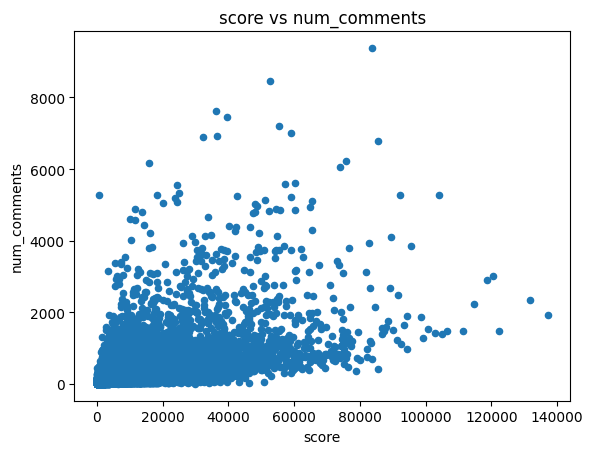

<Figure size 800x600 with 0 Axes>

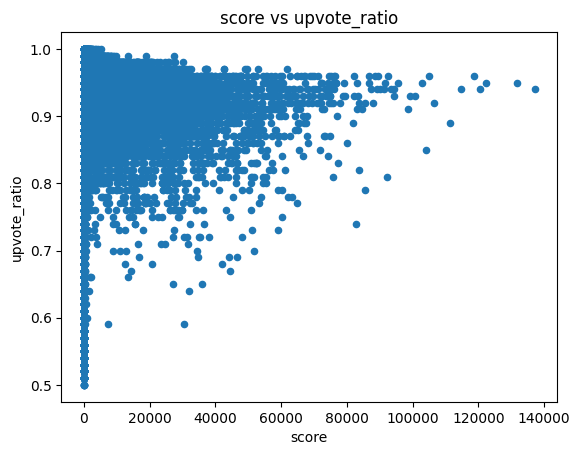

<Figure size 800x600 with 0 Axes>

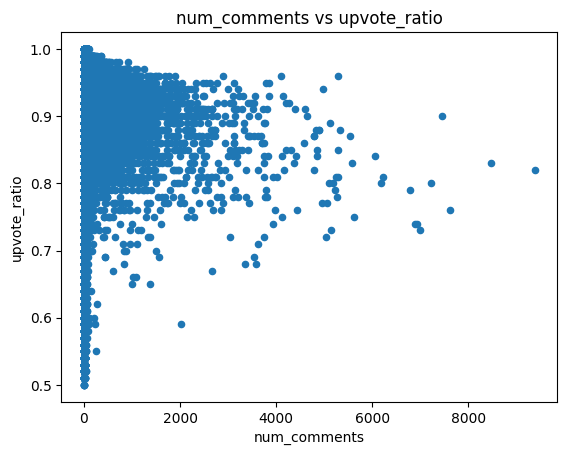

In [27]:
# Scatter plots
numerical_cols = ['score', 'num_comments', 'upvote_ratio']
for i in range(len(numerical_cols)):
    for j in range(i + 1, len(numerical_cols)):
        create_scatter_plot(train_df, numerical_cols[i], numerical_cols[j])

<Figure size 800x600 with 0 Axes>

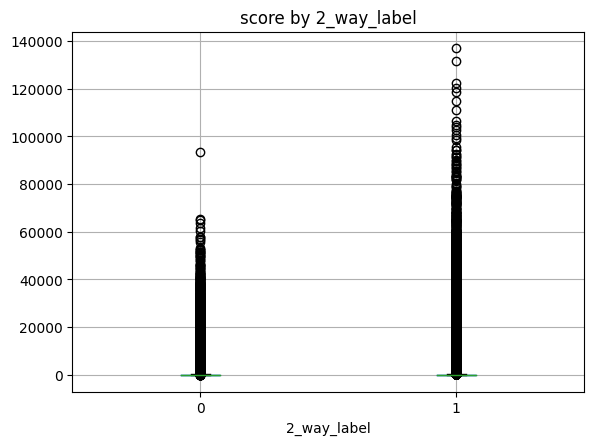

<Figure size 800x600 with 0 Axes>

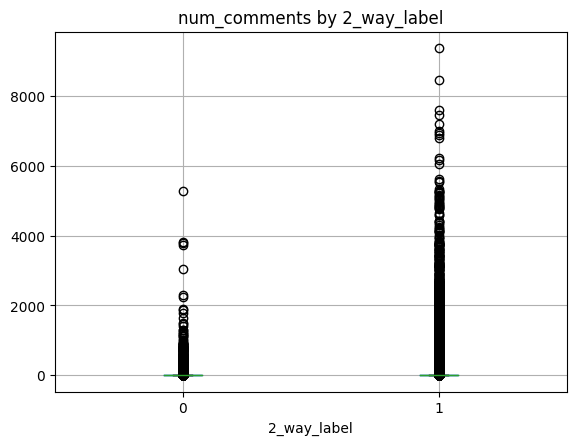

<Figure size 800x600 with 0 Axes>

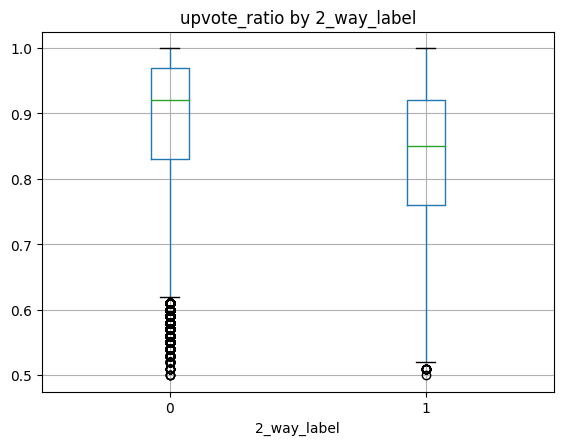

<Figure size 800x600 with 0 Axes>

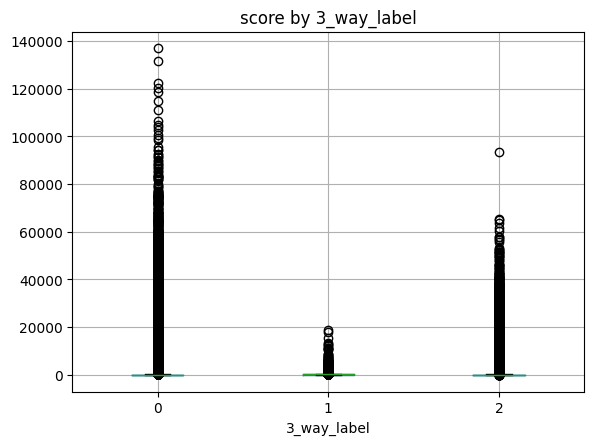

<Figure size 800x600 with 0 Axes>

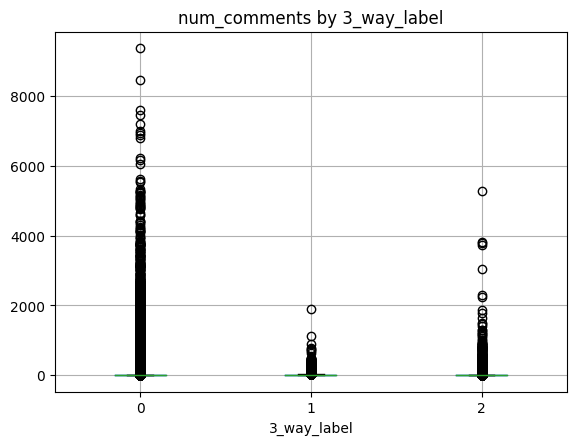

<Figure size 800x600 with 0 Axes>

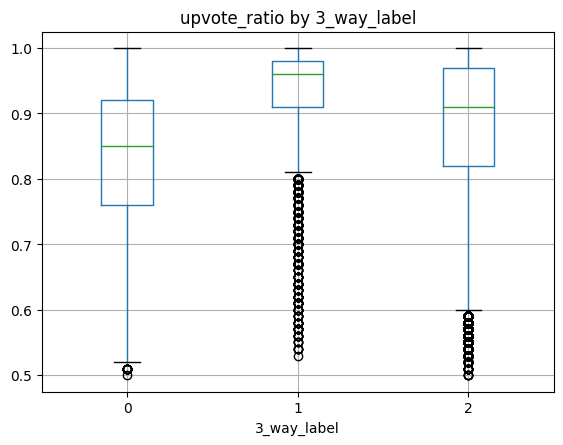

<Figure size 800x600 with 0 Axes>

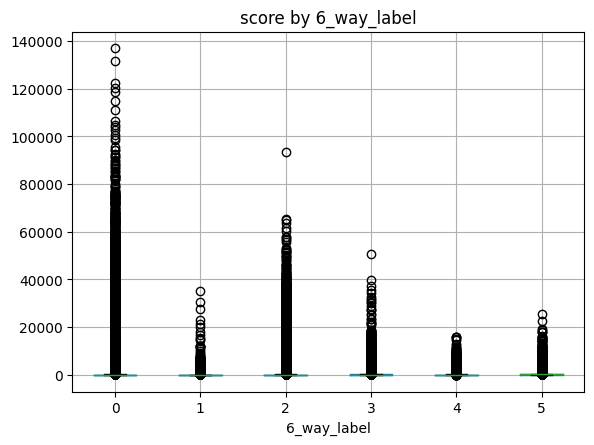

<Figure size 800x600 with 0 Axes>

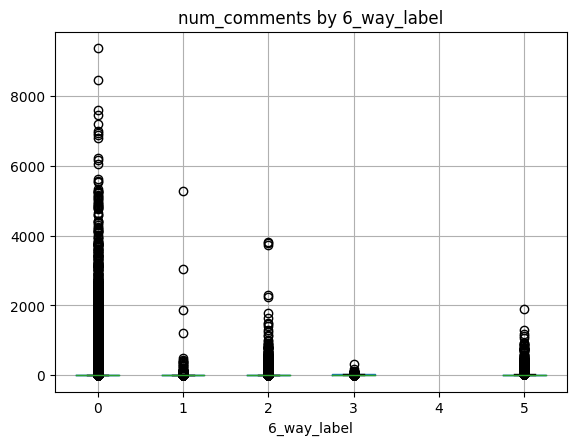

<Figure size 800x600 with 0 Axes>

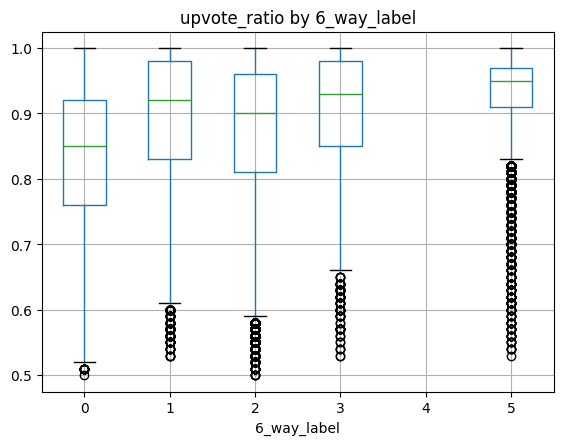

In [28]:
# Box plots
categorical_cols = ['2_way_label', '3_way_label', '6_way_label']
for cat_col in categorical_cols:
    for num_col in numerical_cols:
        create_box_plot(train_df, cat_col, num_col)

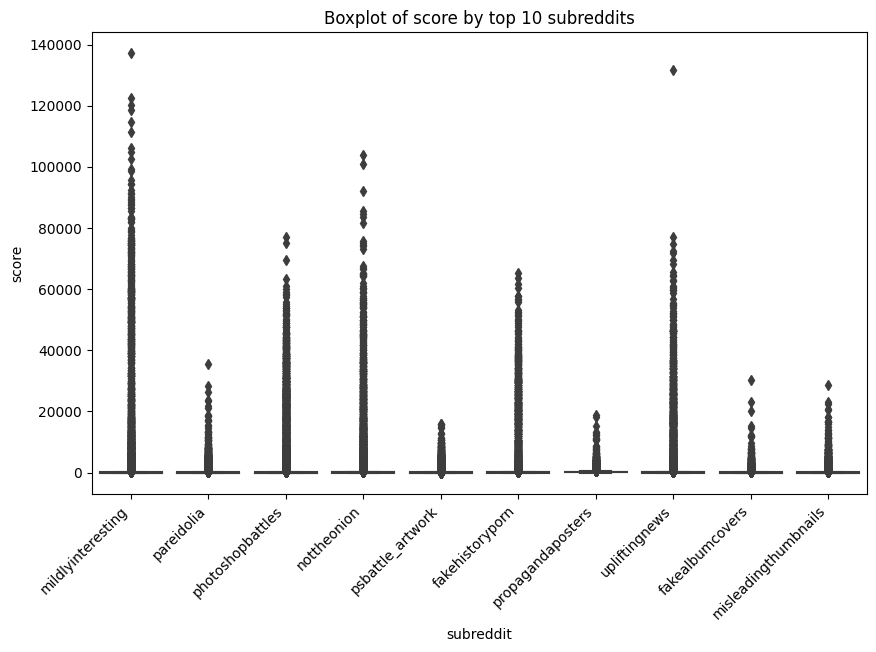

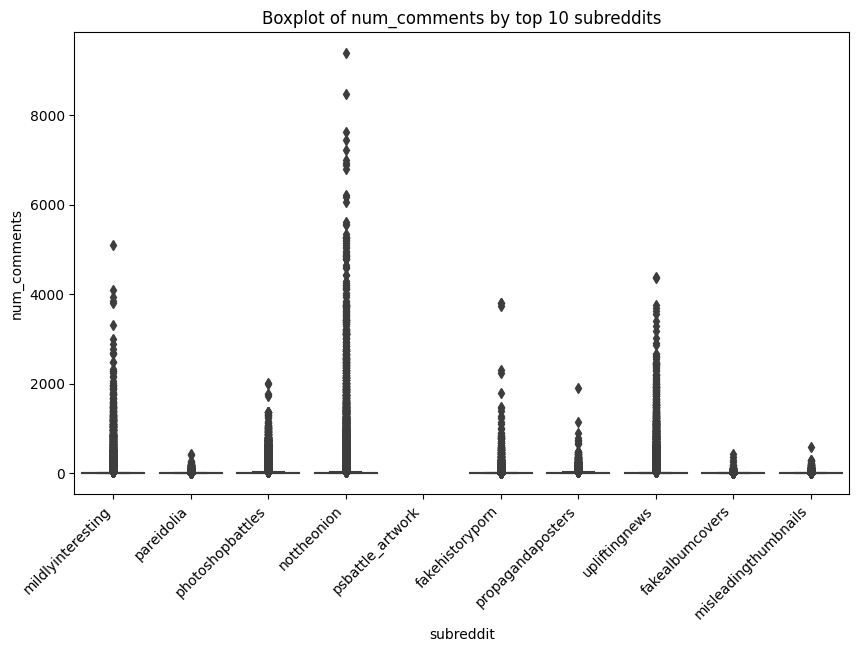

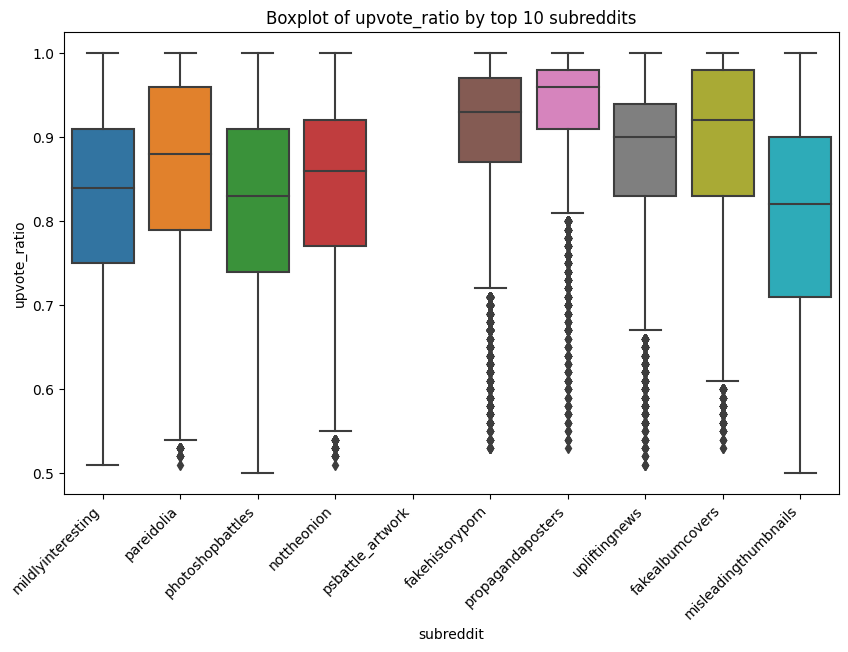

In [33]:
def create_box_plot_for_subreddit(df, num_col):
    # Select top 10 subreddits with the most posts
    top_subreddits = df['subreddit'].value_counts().index[:10]
    subset = df[df['subreddit'].isin(top_subreddits)]

    plt.figure(figsize=(10,6))
    sns.boxplot(x='subreddit', y=num_col, data=subset)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Boxplot of {num_col} by top 10 subreddits")
    plt.show()

for col in numerical_cols:
    create_box_plot_for_subreddit(train_df, col)

## Correlation Matrix

<AxesSubplot:>

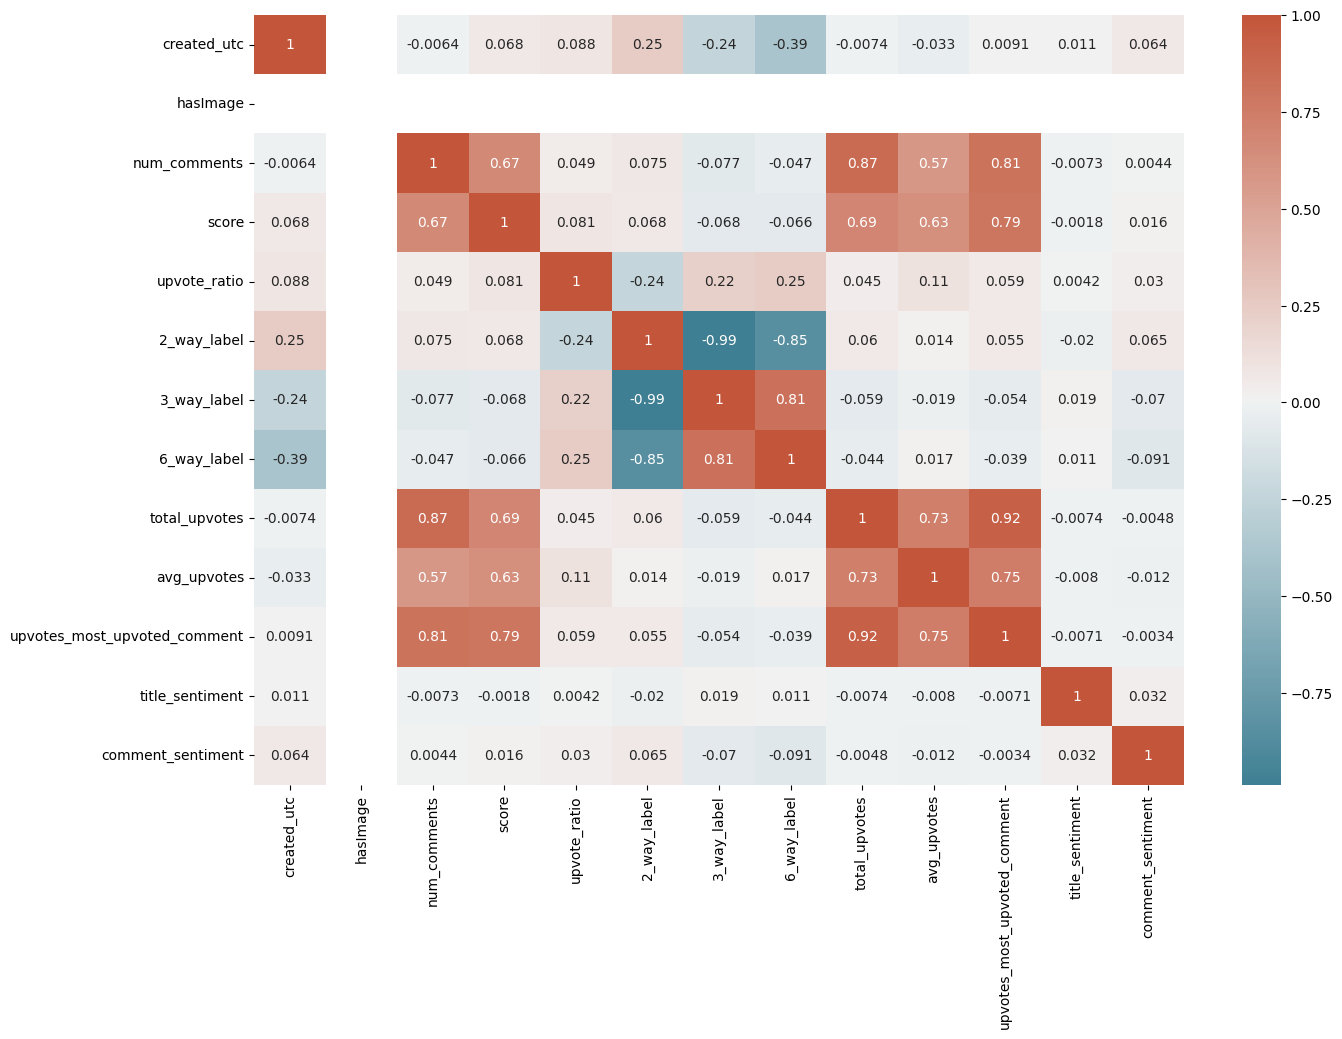

In [29]:
plt.figure(figsize=(15,10))
corr = train_df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))